In [1]:
import os
import numpy as np
import datetime as DT

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Set pandas printout options, for better look
pd.set_option('display.max_row', 15)
pd.set_option('display.max_columns', 15)
pd.set_option('expand_frame_repr', False)
pd.set_option('max_colwidth', 60)

## Set train data root path
root_path = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))

df = pd.read_csv(root_path+'/dataset/userprofiling/'+'query_result_reg_100k.csv',\
                 dtype={'article_id':'str','user_id':'str','city':'str'})

In [2]:
## Create new copy of prior DataFrame and
##  Select only appropriate column
##    and filter empty `topic_id`
df_filter = df.loc[(df['topic_id'] != '') & (df['city'] != '') & (df['os'] != ''), \
    ['user_id','gender','birthdate','event','event_time','city','browser','os','device'\
    ,'carrier','manufacturer','duration','topic_id','article_id']]

# get top 5
df_filter.head(5)

,user_id,gender,birthdate,event,event_time,city,browser,os,device,carrier,manufacturer,duration,topic_id,article_id
0,1026349329,male,10196,read_article,2017-03-07 06:56:59,Jakarta,NaN,Android,NaN,TELKOMSEL,OnePlus,NaN,"22553543,522681656,41566010,46170458,1027266267",1028322564
1,771752788,male,60492,spent_time,2017-02-23 07:43:15,Jakarta,NaN,Android,NaN,TELKOMSEL,samsung,NaN,"361858614,46904429,91265302,27428266",1009162668
2,765731006,female,10196,spent_time,2017-03-10 19:45:39,Jakarta,NaN,Android,NaN,TELKOMSEL,OPPO,NaN,NaN,1032594876
3,27836187,male,62989,like_article,2017-03-20 09:14:44,Jakarta,NaN,Android,NaN,TELKOMSEL,Sony,NaN,"27311918,184387775,184578569,1032823988,40723504",1041353258
4,1018291195,male,10389,view_topic,2017-02-27 14:05:31,Jakarta,Safari,Mac OS X,NaN,NaN,NaN,NaN,27432949,NaN


In [3]:
## Change birthdate format, so we can calculate age of every related id
df_filter['birthdate'] = df_filter['birthdate'].apply('{:06}'.format)
df_filter['birthdate'] = pd.to_datetime(df_filter['birthdate'], format='%m%d%y')

# get bottom 5
df_filter.tail(5)

,user_id,gender,birthdate,event,event_time,city,browser,os,device,carrier,manufacturer,duration,topic_id,article_id
65494,1031036993,female,1991-03-16,like_article,2017-03-26 17:37:06,Jakarta,Safari,Mac OS X,NaN,NaN,NaN,NaN,"22601470,1042354730,1042353997,39154197",1043344842
65495,1020888983,female,1998-06-14,view_topic,2017-03-15 11:31:57,Surabaya,Chrome,Windows,NaN,NaN,NaN,NaN,22551890,NaN
65496,1041858977,male,1972-08-06,spent_time,2017-03-23 14:09:10,Jakarta,NaN,Android,NaN,XL,samsung,NaN,"22662160,27427578,96771233,39303731,47681440",1042799249
65497,316681073,female,1992-02-25,read_article,2017-03-26 16:25:43,Dumai,Firefox,Windows,NaN,NaN,NaN,NaN,"43682262,22601470,36060446,27431099,40378448",1043954301
65498,838577541,female,1983-02-14,read_article,2017-02-25 13:14:19,Yogyakarta,Chrome,Windows,NaN,NaN,NaN,NaN,"22553543,22662160,189694971,39303731,27428761",997368992


In [4]:
now = pd.Timestamp(DT.datetime.now())

## Calculate Age, by subtracting variable now(which is current date) and birtdate
df_filter['birthdate'] = df_filter['birthdate'].where(df_filter['birthdate'] < now, df_filter['birthdate'] -  np.timedelta64(100, 'Y'))
df_filter['birthdate'] = (now - df_filter['birthdate']).astype('<m8[Y]')

## Rename field for better understanding with Database
df_filter.rename(columns={'birthdate': 'age','article_id':'story_id'}, inplace=True)

# get top 5
df_filter.head(5)

,user_id,gender,age,event,event_time,city,browser,os,device,carrier,manufacturer,duration,topic_id,story_id
0,1026349329,male,21.0,read_article,2017-03-07 06:56:59,Jakarta,NaN,Android,NaN,TELKOMSEL,OnePlus,NaN,"22553543,522681656,41566010,46170458,1027266267",1028322564
1,771752788,male,25.0,spent_time,2017-02-23 07:43:15,Jakarta,NaN,Android,NaN,TELKOMSEL,samsung,NaN,"361858614,46904429,91265302,27428266",1009162668
2,765731006,female,21.0,spent_time,2017-03-10 19:45:39,Jakarta,NaN,Android,NaN,TELKOMSEL,OPPO,NaN,NaN,1032594876
3,27836187,male,28.0,like_article,2017-03-20 09:14:44,Jakarta,NaN,Android,NaN,TELKOMSEL,Sony,NaN,"27311918,184387775,184578569,1032823988,40723504",1041353258
4,1018291195,male,28.0,view_topic,2017-02-27 14:05:31,Jakarta,Safari,Mac OS X,NaN,NaN,NaN,NaN,27432949,NaN


* * *

## All unique user_id x Gender

count     3893
unique       3
top       male
freq      2978
Name: gender, dtype: object 

gender
female     911
male      2978
other        4
dtype: int64


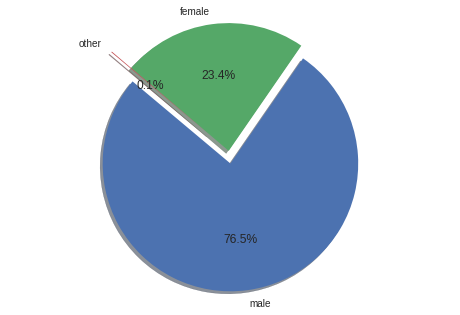

In [5]:
## Get simple data summary
df_gender_unique = df_filter[['user_id','gender']].groupby(['user_id','gender']).size().to_frame()

df_gender_unique.index.names=['user_id','gender']
df_gender_unique.reset_index(inplace=True)
df_gender_unique = df_gender_unique.rename(columns={0: 'count'})

print df_gender_unique['gender'].describe(),"\n"
print df_gender_unique.groupby('gender').size()

labels = df_gender_unique[['gender']].groupby('gender')
groups = dict(list(labels))

plt.pie(list(df_gender_unique.gender.value_counts()), labels=['male','female','other'],\
        autopct='%1.1f%%', shadow=True, startangle=140,\
        explode=(0.1, 0, 0.2))
plt.axis('equal')
plt.show()

## All unique user_id x City

In [6]:
df_city_unique = df_filter[['user_id','city']].groupby(['user_id','city']).size().to_frame()
df_city_unique.index.names=['user_id','city']
df_city_unique.reset_index(inplace=True)
df_city_unique = df_city_unique.rename(columns={0: 'count'})

print df_city_unique['city'].describe(),"\n"
print df_city_unique.groupby('city').size()

count        4622
unique        214
top       Jakarta
freq         2353
Name: city, dtype: object 

city
Abu Dhabi          2
Adiantorop         1
Al Faruq           1
Al Mansurah        1
Ambon City         4
Amsterdam          7
Atlanta            4
                ... 
Wandsworth         1
Wates              1
West New York      1
Xiamen             1
Yogyakarta       137
Yokohama           1
Zhangzhou          1
Length: 214, dtype: int64


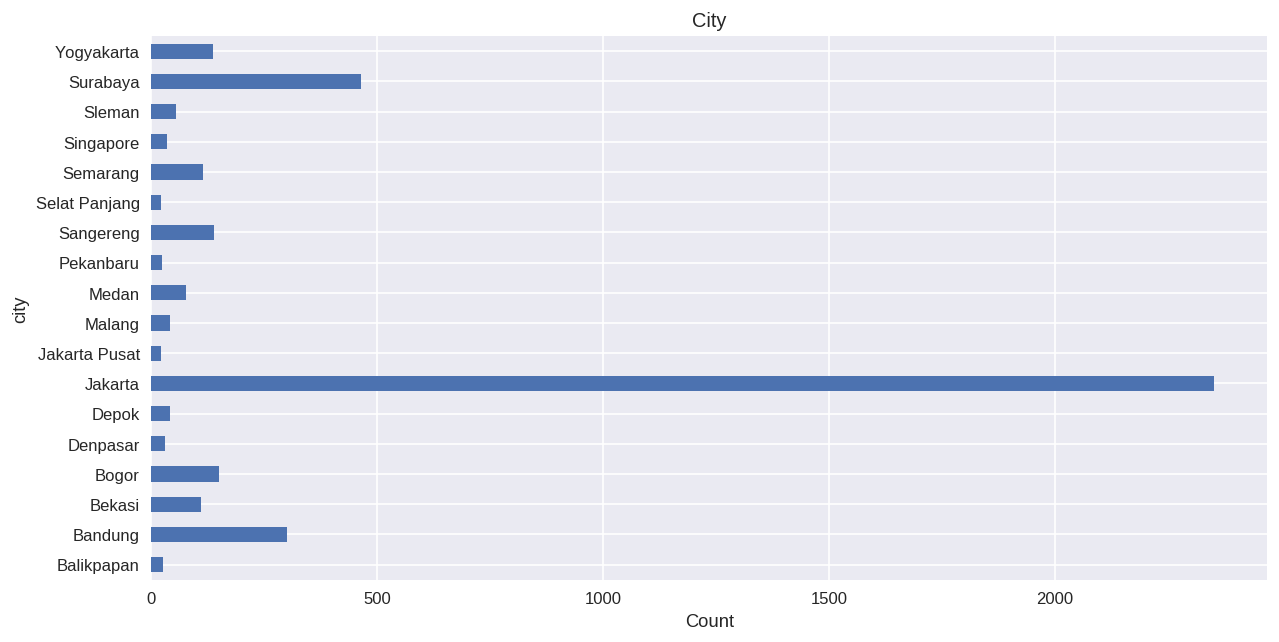

In [7]:
# filter city that only has count that greater 100 and not N-A
cityfilter = df_city_unique[['city']].loc[df_city_unique['city']!='N-A'].groupby(['city']).filter(lambda x: len(x) > 20)

figcity, axcity = plt.subplots(figsize=(12,6), dpi=120)

cityfilter.groupby(['city']).size().plot(kind='barh', stacked=True, title="City", ax=axcity)
plt.xlabel('Count')
plt.show()

## All unique user_id x Gender x City

gender
female    24
male      85
dtype: int64


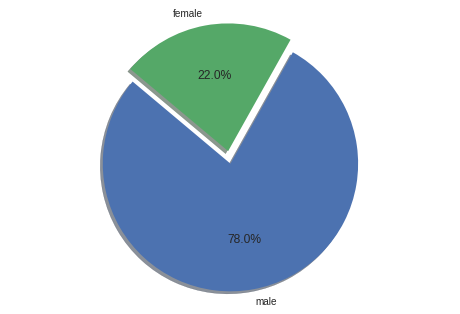

In [8]:
city_to_select = 'bekasi'

df_gender_uncity = df_filter[['user_id','gender']].loc[(df_filter['city'].str.contains(city_to_select, case=False)) & (df_filter['gender']!='other')].groupby(['user_id','gender']).size().to_frame()
df_gender_uncity.index.names=['user_id','gender']
df_gender_uncity.reset_index(inplace=True)
df_gender_uncity = df_gender_uncity.rename(columns={0: 'count'})

print df_gender_uncity.groupby('gender').size()

labels = df_gender_uncity[['gender']].groupby('gender')
groups = dict(list(labels))

plt.pie(list(df_gender_uncity.gender.value_counts()), labels=groups.keys(),\
        autopct='%1.1f%%', shadow=True, startangle=140,\
        explode=(0, 0.1))
plt.axis('equal')
plt.show()